In [1]:
## For debbugging
%load_ext autoreload

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
## for debugging:
%aimport pmml.bn
%aimport pymcnet.net
%aimport pymcnet.expr_parse
%autoreload 1
from pymcnet.net import *
from pmml.bn import *  # for reading in PMML

In [4]:
import pandas as pd
import seaborn as sns
sns.set_style('ticks')
import matplotlib.pyplot as plt
%matplotlib notebook

# PyMCNet
### Bayes-net Prototyping, VIzualizing, Sampling, and I/O
Thurston Sexton

IEEE BD,  December 2017

Problem statement: 
Given a physics model for energy consumption, combined with measurement uncertainty for input lengths
- can we estimate weld density? 
- Given some observed energy consumption measurements, can we update that estimation?

<center><img src="../weld.PNG"></center>


The Volume of a weld cross-section where V and L represent the volume of the weld and the length of the weld respectively. 

$$V = L\left(\frac{3}{4}lh+gt+\frac{l-g}{2}(t-e)\right)$$ 


Assuming the filler and metal are the same material, we model the theoretical enery required for the weld process to be given as 

$$E = \rho(C_p(T_f-T_i)+H)V $$

where $E$, $\rho$, $C_p$, $T_f$, $T_i$, $H$ represent the theoretical minimum energy, density of the material, heat capacity, final and initial temperatures, and latent heat of the material

This can be codified as a Bayes Net. We assume that the dimensioning parameters $l$, $h$, $g$ are random variables, each with unknown distribution parameters $\mu, \sigma$ (assuming they are Normally distributed). 

![net](../weldBN.PNG)
In addition, we have observed values for $l$, $h$, $g$, allowing us to update the posterior distribution using MCMC (Or, in the case of PyMC3, the No-U-Turn Sampler a.k.a. NUTS)

Let's assume a uniform prior on the distribution parameters, and let the majority of the other parameters be constant/known. With the availability of some hypothetical energy meter (easy to measure), we want to estimate the distribution for $\rho$, which is an input to $E$ in the equation above. This makes $E,V$ *deterministic* variables. 

Using Daft to draw this PGM, we get a model like this:


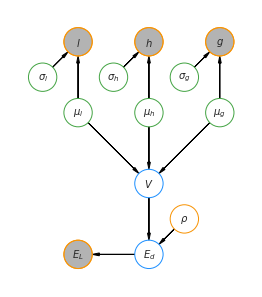

In [161]:
import daft

# Colors.
p_color = {"ec": "#46a546"}
s_color = {"ec": "#f89406"}
d_color = {"ec": "#1e90ff"}

pgm = daft.PGM([3.5, 4], origin=[0, .5], grid_unit=2.5)

l = daft.Node("l", "$l$", 1, 4, plot_params=s_color, observed=True)
h = daft.Node("h", "$h$", 2, 4, plot_params=s_color, observed=True)
e = daft.Node("g", "$g$", 3, 4, plot_params=s_color, observed=True)
# l.va = "baseline"
pgm.add_node(l)
pgm.add_node(h)
pgm.add_node(e)
pgm.add_node(daft.Node("sd_l", r"$\sigma_l$", .5, 3.5, plot_params=p_color))
pgm.add_node(daft.Node("mu_l", r"$\mu_l$", 1, 3, plot_params=p_color))
pgm.add_edge("mu_l", "l")
pgm.add_edge("sd_l", "l")

pgm.add_node(daft.Node("sd_h", r"$\sigma_h$", 1.5, 3.5, plot_params=p_color))
pgm.add_node(daft.Node("mu_h", r"$\mu_h$", 2, 3, plot_params=p_color))
pgm.add_edge("mu_h", "h")
pgm.add_edge("sd_h", "h")

pgm.add_node(daft.Node("sd_g", r"$\sigma_g$", 2.5, 3.5, plot_params=p_color))
pgm.add_node(daft.Node("mu_g", r"$\mu_g$", 3, 3, plot_params=p_color))
pgm.add_edge("mu_g", "g")
pgm.add_edge("sd_g", "g")

pgm.add_node(daft.Node("V", "$V$", 2, 2, plot_params=d_color))
# pgm.add_node(daft.Node("sd_V", r"$\sigma_V$", 1, 2, plot_params=p_color))
# pgm.add_edge("sd_V", "V")
pgm.add_edge("mu_l", "V")
pgm.add_edge("mu_h", "V")
pgm.add_edge("mu_g", "V")


pgm.add_node(daft.Node("E", "$E_d$", 2, 1, plot_params=d_color))
# pgm.add_node(daft.Node("sd_E", r"$\sigma_E$", 1, 1, plot_params=p_color))
pgm.add_node(daft.Node("rho", r"$\rho$", 2.5, 1.5, plot_params=s_color))
pgm.add_node(daft.Node("E_L", "$E_L$", 1, 1, plot_params=s_color, observed=True))
# pgm.add_edge("sd_E", "E")
pgm.add_edge("rho", "E")
pgm.add_edge("V", "E")
pgm.add_edge("E", "E_L")
pgm.render()
pgm.figure.savefig("weld_net_img.png", dpi=400)

### Sampling the prior and posterior
To get an approximation for our current belief in the distribution for minimum energy usage, we will perform sampling without any observations, and then we will add observation attributes to the network

#### First, we need some "observed data"

<IPython.core.display.Javascript object>


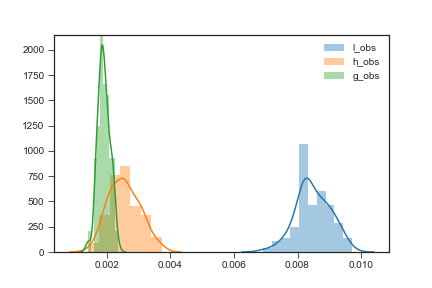

/home/tbsexton/anaconda3/envs/pymcnet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tbsexton/anaconda3/envs/pymcnet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tbsexton/anaconda3/envs/pymcnet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<IPython.core.display.Javascript object>


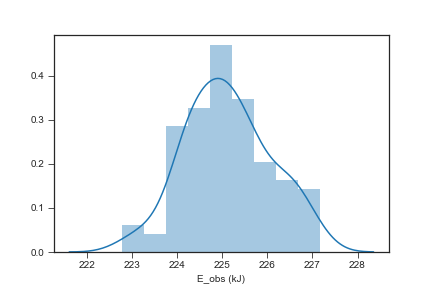

/home/tbsexton/anaconda3/envs/pymcnet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'E_obs (kJ)')

In [9]:
from scipy.stats import norm
import numpy as np
# Synthetic Data-set (observations)
np.random.seed(19806) #random.org, for reproduceability

num_obs = 100
l_obs = norm(8.5, 0.5).rvs(size=100)*1e-3  # m
h_obs = norm(2.6, 0.5).rvs(size=100)*1e-3  # m
g_obs = norm(1.9, .19).rvs(size=100)*1e-3  # m
E_obs = norm(225, 1).rvs(size=100)  # kJ
synth = pd.DataFrame(data=np.array([l_obs, h_obs, g_obs, E_obs]).T, 
                     columns=['l','h','g', 'E'])
for i in [l_obs, h_obs, g_obs]:
    sns.distplot(i)
plt.legend([
    'l_obs',
    'h_obs',
    'g_obs'
])
plt.figure()
sns.distplot(synth.E)
plt.xlabel('E_obs (kJ)')

### The unobserved (a.k.a. "prior") network: 

If you already know how to build networks using NetworkX, it's easy to model this BN. Nodes that depend on others will get a string definition in an `exprs` property, while independent nodes can simply receive their values directly --- after compilation the exprs property will be parsed into a form like the independent nodes, but using **Theano** shared variables. 

With this approach to prototyping, we can immediately check our model graphically without needing to compile the theano graph. 

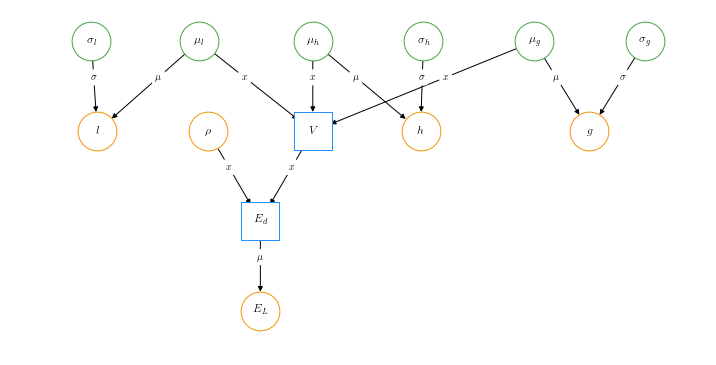

In [35]:
D = BayesianNetwork()

D.add_node('mu_l',
           lower=8.3e-3, upper=8.6e-3,
           dist_type='Uniform')
D.add_node('sd_l',
           lower=0.2e-3, upper=0.7e-3,
           dist_type='Uniform')

D.add_node('l',
           dist_type='Normal',
           exprs = {'mu':'mu_l',
                    'sd':'sd_l'})
D.add_edge('mu_l','l', var='mu')
D.add_edge('sd_l', 'l', var='sd')

D.add_node('mu_h',
           lower=2.5e-3, upper=2.8e-3,
           dist_type='Uniform')
D.add_node('sd_h',
           lower=0.3e-3, upper=0.6e-3,
           dist_type='Uniform')

D.add_node('h',
           dist_type='Normal',
           exprs = {'mu':'mu_h',
                    'sd':'sd_h'})
D.add_edge('mu_h','h', var='mu')
D.add_edge('sd_h', 'h', var='sd')

D.add_node('mu_g',
           lower=1.6e-3, upper=2.2e-3,
           dist_type='Uniform')
D.add_node('sd_g',
           lower=0.05e-3, upper=.2e-3,
           dist_type='Uniform')

D.add_node('g',
           dist_type='Normal',
           exprs = {'mu':'mu_g',
                    'sd':'sd_g'})
D.add_edge('mu_g','g', var='mu')
D.add_edge('sd_g', 'g', var='sd')

e = .011  # m
L = .500  # m
t = .015  # m

# Volume (m^3)
D.add_node('V',
           dist_type='Deterministic',
           exprs = {'var':f'{L}*((0.75)*mu_l*mu_h + mu_g*{t} + (mu_l-mu_g)*({t}-{e})*0.5)'})

D.add_edges_from([(i,'V') for i in ['mu_l','mu_h','mu_g']],
                 var='x')

# Density (kg/m^3)
D.add_node('rho',
           mu=8250., sd=10.,
          dist_type='Normal')

H=270.     # kJ/kg
C_p=0.5    # kJ/kgK
T_i=300.   # K
T_f=1600.  # K

# D.add_node('eps_E',
#            mu=0., sd=1e4,
#            dist_type = 'Normal')

# Energy (kJ)
D.add_node('E_d',  
           dist_type = 'Deterministic',
           exprs={'var':f'rho*V*({C_p}*({T_f}-{T_i}) + {H})'})
D.add_edges_from([(i, 'E_d') for i in ['rho','V']], var='var')


# Model Likelihood
D.add_node('E_L',  # kJ
           dist_type = 'Normal',
           exprs={'mu':'E_d',
                  'sd':'1.0'})
D.add_edge('E_d','E_L', var='mu')


draw_net(D, pretty=True)

#### The observations can be easily added in: 
Note the graph visualization automatically checks for observed nodes

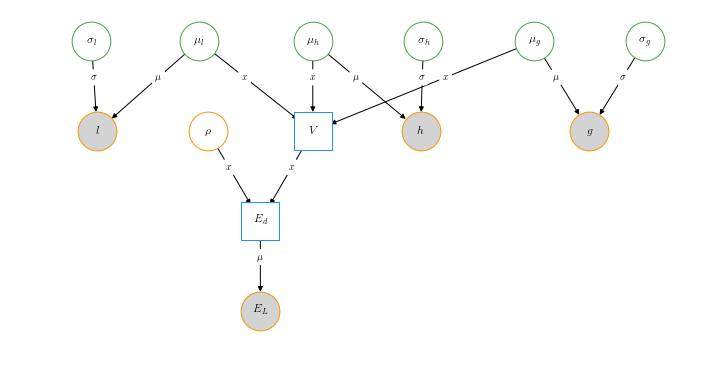

In [36]:
# import theano.tensor as T
# O = BayesianNetwork()
import copy

O = copy.deepcopy(D)
O.node['l']['observed'] = synth['l']
O.node['h']['observed'] = synth['h']
O.node['g']['observed'] = synth['g']
O.node['E_L']['observed'] = synth['E']


draw_net(O, pretty=True)

### Instantiation (i.e. Theano Comiling) and Sampling is easy!

In [38]:
n_samp = 2000

with pm.Model() as prior_model:
#     db_prior = pm.backends.Text('trace_prior_file')

    instantiate_pm(D, evaluate_exprs=True)
#     start=pm.find_MAP()
    trace_prior = pm.sample(n_samp, tune=1000, cores=1, chains=3)

mu_l
root node; keys:  ['lower', 'upper']
sd_l
root node; keys:  ['lower', 'upper']
l
child node; keys:  ['sd', 'mu']
mu_h
root node; keys:  ['lower', 'upper']
sd_h
root node; keys:  ['lower', 'upper']
h
child node; keys:  ['sd', 'mu']
mu_g
root node; keys:  ['lower', 'upper']
sd_g
root node; keys:  ['lower', 'upper']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


g
child node; keys:  ['sd', 'mu']
V
child node; keys:  ['var']
rho
root node; keys:  ['sd', 'mu']
E_d
child node; keys:  ['var']
E_L
child node; keys:  ['sd', 'mu']


Sequential sampling (3 chains in 1 job)
NUTS: [E_L, rho, g, sd_g_interval__, mu_g_interval__, h, sd_h_interval__, mu_h_interval__, l, sd_l_interval__, mu_l_interval__]
100%|██████████| 3000/3000 [01:01<00:00, 48.76it/s]
The acceptance probability does not match the target. It is 0.896202621448, but should be close to 0.8. Try to increase the number of tuning steps.


In [39]:
with pm.Model() as model:
#     db = pm.backends.Text('trace_file')
    instantiate_pm(O, evaluate_exprs=True)
#     start = pm.find_MAP()
    trace = pm.sample(n_samp, cores=1, tune=1000, chains=3)


mu_l
root node; keys:  ['lower', 'upper']
sd_l
root node; keys:  ['lower', 'upper']
l
child node; keys:  ['observed', 'sd', 'mu']
mu_h
root node; keys:  ['lower', 'upper']
sd_h
root node; keys:  ['lower', 'upper']
h
child node; keys:  ['observed', 'sd', 'mu']
mu_g
root node; keys:  ['lower', 'upper']
sd_g
root node; keys:  ['lower', 'upper']
g
child node; keys:  ['observed', 'sd', 'mu']
V
child node; keys:  ['var']
rho
root node; keys:  ['sd', 'mu']
E_d
child node; keys:  ['var']
E_L
child node; keys:  ['observed', 'sd', 'mu']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [rho, sd_g_interval__, mu_g_interval__, sd_h_interval__, mu_h_interval__, sd_l_interval__, mu_l_interval__]
100%|██████████| 3000/3000 [00:20<00:00, 143.14it/s]


#### Plot the updated belief

In [153]:
def set_style():
    # This sets reasonable defaults for font size for a figure that will go in a paper
    sns.set_context("paper")

    # Set the font to be serif, rather than sans
    sns.set(font='serif')

    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"],
        "font.size": 16
    })
set_style()


/home/tbsexton/anaconda3/envs/pymcnet/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


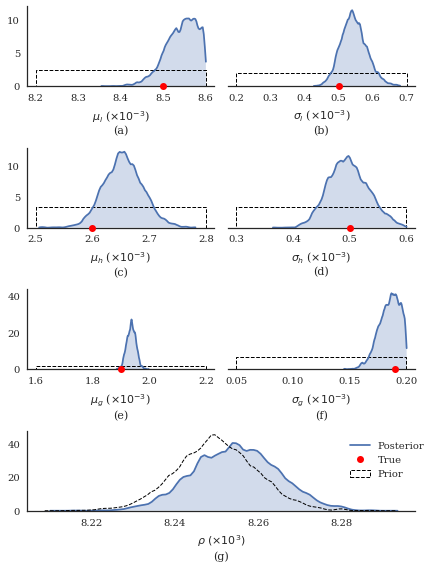

In [181]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

lims = [(8.2e-3, 8.6e-3),
        (0.2e-3, 0.7e-3),
        (2.5e-3, 2.8e-3),
        (0.3e-3, 0.6e-3),
        (1.6e-3, 2.2e-3),
        (.05e-3, 0.2e-3)]
trues = [8.5, 0.5, 2.6, 0.5, 1.9, .19]
varnames=['mu_l', 'sd_l',
          'mu_h', 'sd_h',
          'mu_g', 'sd_g']
varlabs= [r'$\mu_l$', r'$\sigma_l$',
          r'$\mu_h$', r'$\sigma_h$',
          r'$\mu_g$', r'$\sigma_g$']

def compare_dist(ax, dat, lim, true=None, scale=1.):

    a,b = scale*lim[0], scale*lim[1]
    y = 1./(b-a)
    sns.kdeplot(scale*dat, ax=ax, label='Posterior', 
             shade=True, legend=False, cut=.1, kernel='epa')
    rect = patches.Rectangle((a,0), b-a, y,
                             linewidth=1,edgecolor='k',ls='--',
                             facecolor='none', label='Prior')
    ax.add_patch(rect)
    if true is not None:
        ax.plot(true,0, marker='o', color='r', 
                zorder=10, clip_on=False, label='True', linestyle='')
#     ax.errorbar(true[0], 0., xerr=)
#     ax.legend()

    
f = plt.figure(tight_layout=True, figsize=(6,8))
gs = gridspec.GridSpec(4, 2)

figrefs = 'abcdef'
for n in range(6):
    kws={}
    y_viz, left = True, False
    if n%2==1:
        kws['sharey']=ax
        y_viz, left = False, True
    
    ax = f.add_subplot(gs[n//2, n%2], **kws)
    ax.get_yaxis().set_visible(y_viz)
    
    compare_dist(ax, trace.get_values(D.d(varnames[n])), lims[n], true=trues[n], scale=1e3)
    ax.set_xlabel(f"{varlabs[n]}"+ r" ($\times10^{-3}$)" + f'\n({figrefs[n]})')
    sns.despine(ax=ax, left=left)
    
        
ax2 = f.add_subplot(gs[3,:])
sns.kdeplot(trace.get_values('rho')*1e-3, ax=ax2, 
             label='Posterior', shade=True, legend=False, kernel='epa')
prior_dist = sns.kdeplot(trace_prior.get_values('rho')*1e-3, ax=ax2, 
                         label='Prior', color='k', ls='--', 
                         linewidth=1, legend=False, kernel='epa')

# ax.legend()
ax2.set_xlabel(r'$\rho$ $(\times 10^{3})$' + '\n(g)')
sns.despine(ax=ax2)
# plt.xlim(10,35)
# plt.show()
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc=(.8,.15))
plt.savefig('bn-inference.png', dpi=400)

In [117]:
prior_dist.lines[0]

#### Check convergence of the Sampler

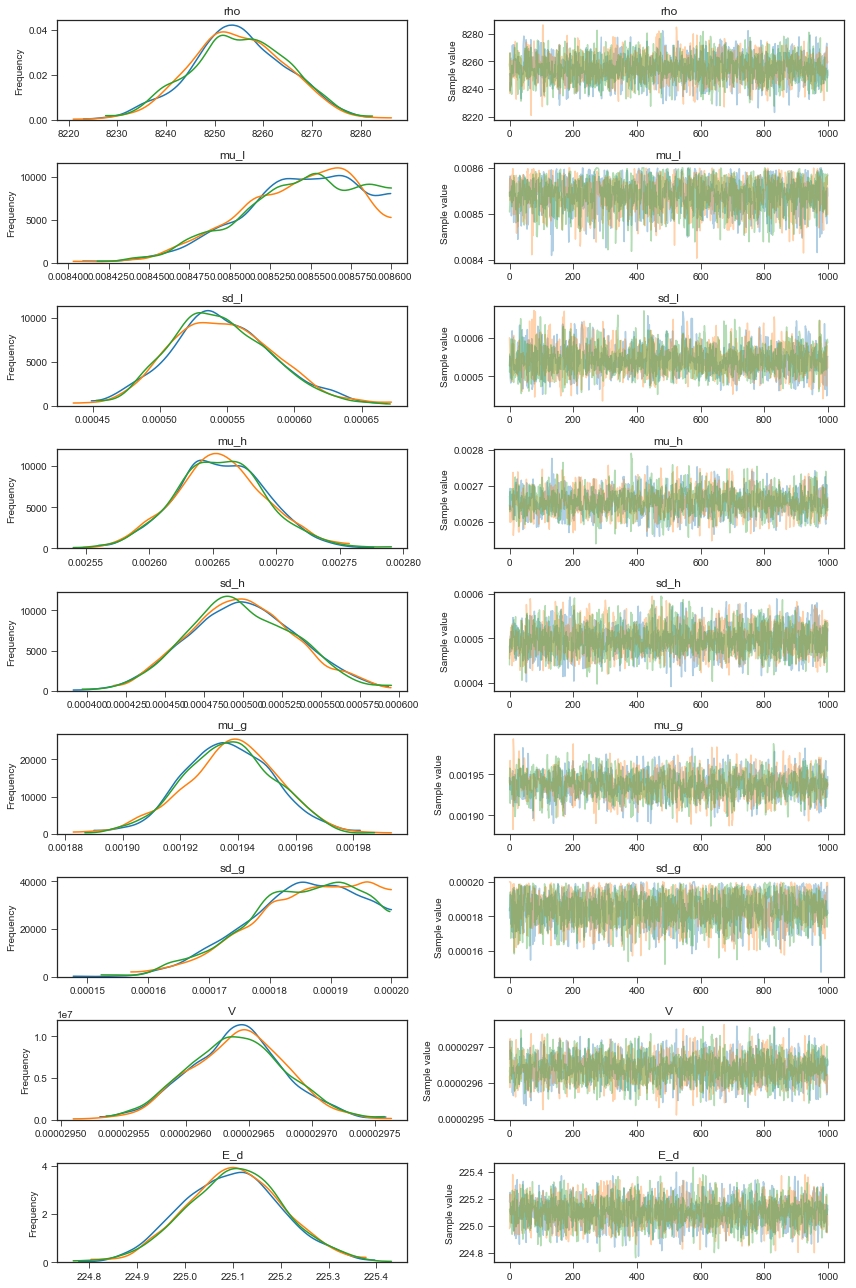

In [41]:
pm.traceplot(trace[n_samp//2:], combined=False);

### Serialization
This model is compatible with the PMML parser contained in this package. To save it, just call the `toPMML()` network method 

In [46]:
O.toPMML('WeldModelPMML.xml')

mu_l
	 Lower 0.0083
	 Upper 0.0086
sd_l
	 Lower 0.0002
	 Upper 0.0007
l
	 Variance (sd_l)**2.
	 Mean mu_l
mu_h
	 Lower 0.0025
	 Upper 0.0028
sd_h
	 Lower 0.0003
	 Upper 0.0006
h
	 Variance (sd_h)**2.
	 Mean mu_h
mu_g
	 Lower 0.0016
	 Upper 0.0022
sd_g
	 Lower 5e-05
	 Upper 0.0002
g
	 Variance (sd_g)**2.
	 Mean mu_g
V
	 Mean 0.5*((0.75)*mu_l*mu_h + mu_g*0.015 + (mu_l-mu_g)*(0.015-0.011)*0.5)
rho
	 Variance 100.0
	 Mean 8250.0
E_d
	 Mean rho*V*(0.5*(1600.0-300.0) + 270.0)
E_L
	 Variance (1.0)**2.
	 Mean E_d
Wrote PMML file to WeldModelPMML.xml


## Reading PMML Files In 

Given some PMML bayes-net file, we can import into our BayesianNetwork graph object, and immediately instantiate into a PyMC3 model. 

Let's try it now: 

In [47]:
bnp = BayesianNetworkParser()

soG = bnp.parse('WeldModelPMML.xml')
soG.node

mu_l
	lower 0.0083
	upper 0.0086
sd_l
	lower 0.0002
	upper 0.0007
l
	mu ['mu_l']
	sd ['sd_l']
mu_h
	lower 0.0025
	upper 0.0028
sd_h
	lower 0.0003
	upper 0.0006
h
	mu ['mu_h']
	sd ['sd_h']
mu_g
	lower 0.0016
	upper 0.0022
sd_g
	lower 5e-05
	upper 0.0002
g
	mu ['mu_g']
	sd ['sd_g']
V
	mu ['mu_l', 'mu_g', 'mu_h', 'mu_l']
	sd []
Deterministic Node V detected as N(mu, 0); replacing...
rho
	mu 8250.0
	sd 100.0
E_d
	mu ['V', 'rho']
	sd []
Deterministic Node E_d detected as N(mu, 0); replacing...
E_L
	mu ['E_d']
	sd []


NodeView(('mu_l', 'sd_l', 'l', 'mu_h', 'sd_h', 'h', 'mu_g', 'sd_g', 'g', 'V', 'rho', 'E_d', 'E_L'))

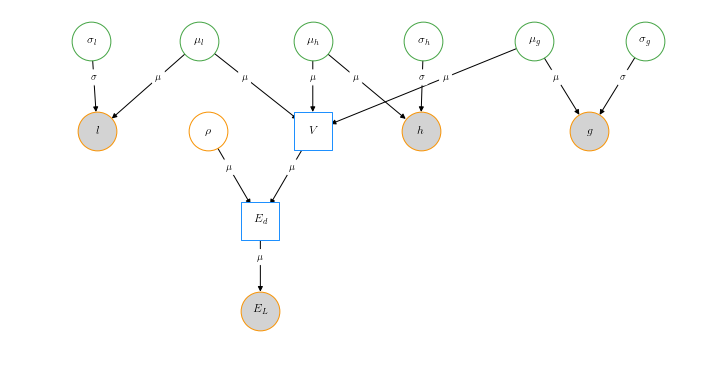

In [48]:
draw_net(soG, pretty=True)

Note that PMML as implemented here does not save the training/observation data, but it will flag which nodes are *supposed* to be observed, as specified in the XML document (note the yellow nodes above). 

We can make another net that will contain the observations, and then set off PyMC3 to do our sampling:

In [50]:
soO = copy.deepcopy(soG)
soO.node['l']['observed'] = synth['l']
soO.node['h']['observed'] = synth['h']
soO.node['g']['observed'] = synth['g']
soO.node['E_L']['observed'] = synth['E']


n_samp = 2000

with pm.Model() as prior_model:
    instantiate_pm(soG, evaluate_exprs=True)
    trace_prior = pm.sample(n_samp, cores=1)

with pm.Model() as model:
    instantiate_pm(soO, evaluate_exprs=True)
    trace = pm.sample(n_samp, cores=1)

mu_l
root node; keys:  ['lower', 'upper']
sd_l
root node; keys:  ['lower', 'upper']
l
child node; keys:  ['observed', 'sd', 'mu']
mu_h
root node; keys:  ['lower', 'upper']
sd_h
root node; keys:  ['lower', 'upper']
h
child node; keys:  ['observed', 'sd', 'mu']
mu_g
root node; keys:  ['lower', 'upper']
sd_g
root node; keys:  ['lower', 'upper']
g
child node; keys:  ['observed', 'sd', 'mu']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


V
child node; keys:  ['var']
rho
root node; keys:  ['sd', 'mu']
E_d
child node; keys:  ['var']
E_L
child node; keys:  ['observed', 'sd', 'mu']


Sequential sampling (2 chains in 1 job)
NUTS: [rho, sd_g_interval__, mu_g_interval__, sd_h_interval__, mu_h_interval__, sd_l_interval__, mu_l_interval__]
100%|██████████| 2500/2500 [00:04<00:00, 602.80it/s]


mu_l
root node; keys:  ['lower', 'upper']
sd_l
root node; keys:  ['lower', 'upper']
l
child node; keys:  ['observed', 'sd', 'mu']
mu_h
root node; keys:  ['lower', 'upper']
sd_h
root node; keys:  ['lower', 'upper']
h
child node; keys:  ['observed', 'sd', 'mu']
mu_g
root node; keys:  ['lower', 'upper']
sd_g
root node; keys:  ['lower', 'upper']
g
child node; keys:  ['observed', 'sd', 'mu']


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


V
child node; keys:  ['var']
rho
root node; keys:  ['sd', 'mu']
E_d
child node; keys:  ['var']
E_L
child node; keys:  ['observed', 'sd', 'mu']


Sequential sampling (2 chains in 1 job)
NUTS: [rho, sd_g_interval__, mu_g_interval__, sd_h_interval__, mu_h_interval__, sd_l_interval__, mu_l_interval__]
100%|██████████| 2500/2500 [00:17<00:00, 141.34it/s]


/home/tbsexton/anaconda3/envs/pymcnet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tbsexton/anaconda3/envs/pymcnet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tbsexton/anaconda3/envs/pymcnet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tbsexton/anaconda3/envs/pymcnet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is dep

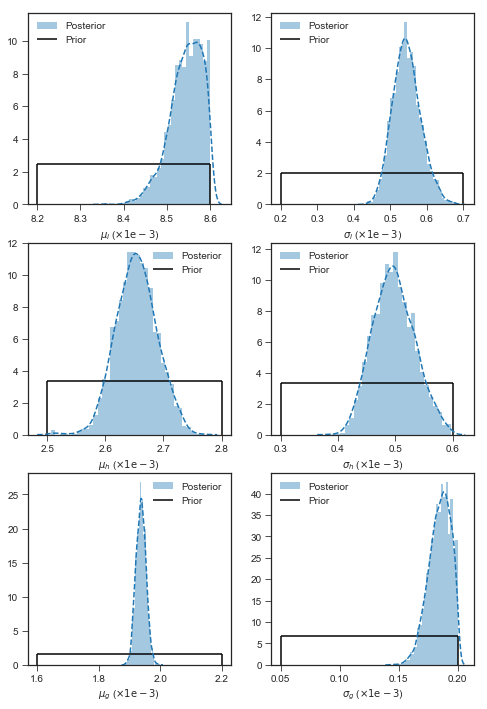

/home/tbsexton/anaconda3/envs/pymcnet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/tbsexton/anaconda3/envs/pymcnet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


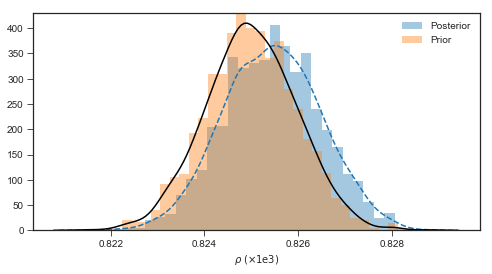

In [51]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,12))

for n, ax in enumerate(axes.flat):
    compare_dist(ax, trace[n_samp//2:].get_values(D.d(varnames[n])), lims[n], scale=1e3)
    ax.set_xlabel(f"{varlabs[n]}"+ r" ($\times 1\mathrm{e}-3$)")
plt.show()

f2 = plt.figure(figsize=(8,4))
sns.distplot(trace[n_samp//2:].get_values('rho')*1e-4, kde=True, label='Posterior', kde_kws={'ls':'--'})
sns.distplot(trace_prior[n_samp//2:].get_values('rho')*1e-4, label='Prior', kde_kws={'color':'k'})
plt.legend()
plt.xlabel(r'$\rho$ $(\times 1\mathrm{e}3)$')
# plt.xlim(15,35)
plt.show()

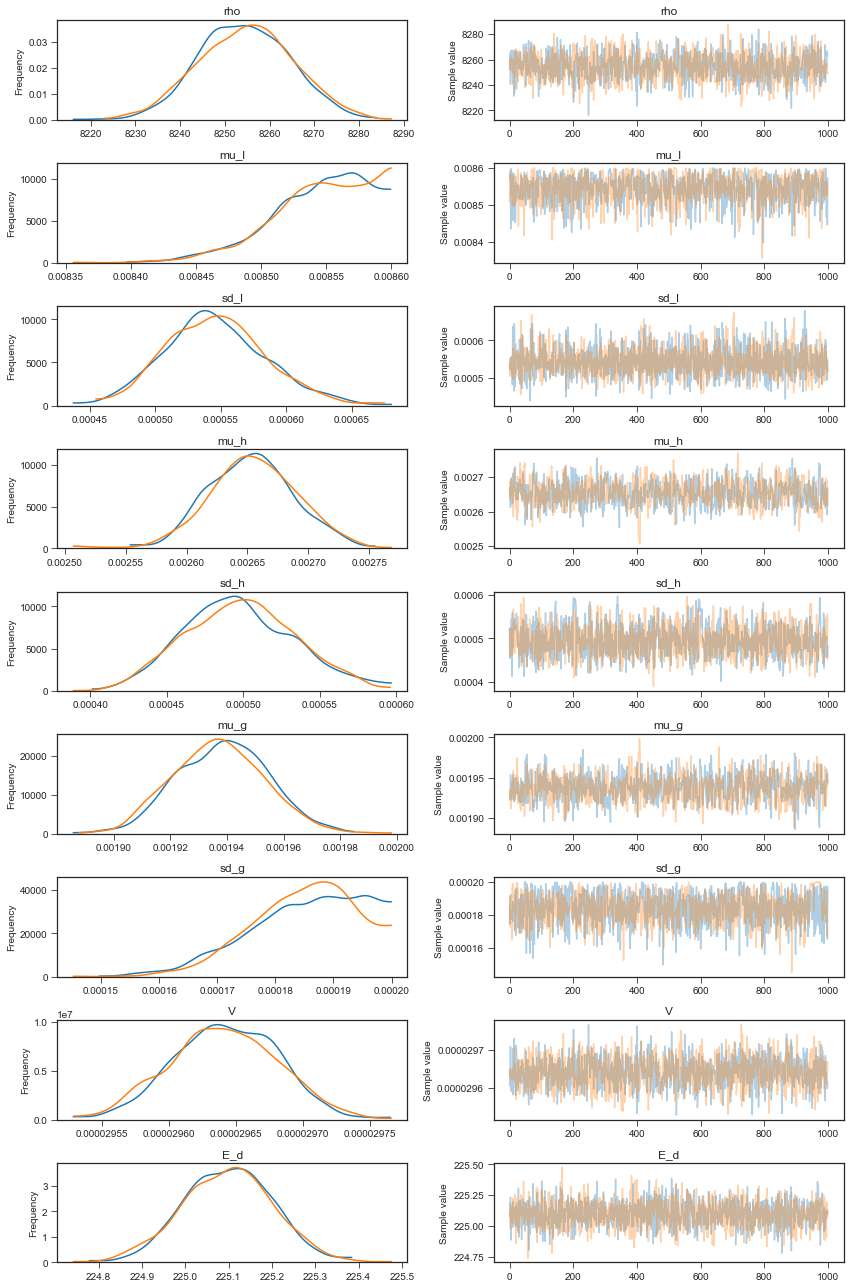

In [52]:
pm.traceplot(trace[n_samp//2:]);